# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- Emiljano Gjiriti,
    2- Siyuan Li,
    3- Junze Li

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

In [30]:
import tarfile
import os
import numpy as np
import cv2 as cv

from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian

import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from skimage.measure import label
from skimage.filters import sobel
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage import color
from skimage import measure
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage import data, exposure
import matplotlib.patches as mpatches
from skimage.morphology import disk

import xml.etree.ElementTree as ET
from skimage.transform import resize
from sklearn.decomposition import PCA

### Load the data

In [36]:
def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

def annots_to_coords(annots):
    coords = []
    for an in annots:
        coords.append(np.array(an['bbox']))
    
    return np.array(coords)

In [32]:
data_file = './project-data.tar.gz'
data_folder = './'
with tarfile.open(data_file, mode='r:gz') as tar:
    tar.extractall(path = data_folder)

In [33]:
data_folder_extract = os.path.join(data_folder,'project-data/images')
train_images = os.path.join(data_folder_extract,'train')
test_images = os.path.join(data_folder_extract,'test')
annotations_train = os.path.join(data_folder,'project-data/annotations/train')
annotations_test = os.path.join(data_folder,'project-data/annotations/test')

In [34]:
f = open(os.path.join(data_folder,"./project-data/train.txt"))
im_names_train = []
for line in f:
    im_names_train.append(line.rstrip())

filenames_train = [os.path.join(train_images, name) + '.jpg' for name in im_names_train]
annotations_xmls_train = [parse_file(os.path.join(annotations_train, name) + '.xml') for name in im_names_train]
ic_train = skimage.io.imread_collection(filenames_train)

In [35]:
f = open(os.path.join(data_folder,"./project-data/test.txt"))
im_names_test = []
for line in f:
    im_names_test.append(line.rstrip())

filenames_test = [os.path.join(test_images, name) + '.jpg' for name in im_names_test]
annotations_xmls_test = [parse_file(os.path.join(annotations_test, name) + '.xml') for name in im_names_test]
ic_test = skimage.io.imread_collection(filenames_test)

### Visualize the annotation

In [619]:
area_list = []
for i in range(len(ic_train)):
    anno = annotations_xmls_train[i]
    for num in anno:
        area = num['bbox'][2]*num['bbox'][3]
        area_list.append(area)

We plot the histogram of the area of the ground truth bounding box, which can help us to choose the threshold for the image segmentation method later.

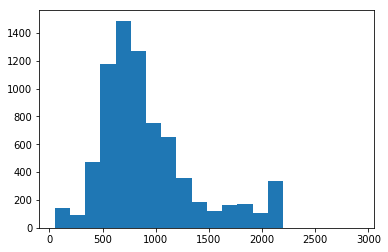

In [622]:
plt.hist(area_list,bins = 20);

In [621]:
print("There are {} train images and {} test images.".format(len(ic_train),len(ic_test)))

There are 800 train images and 50 test images.


###  Visualize Test Image samples

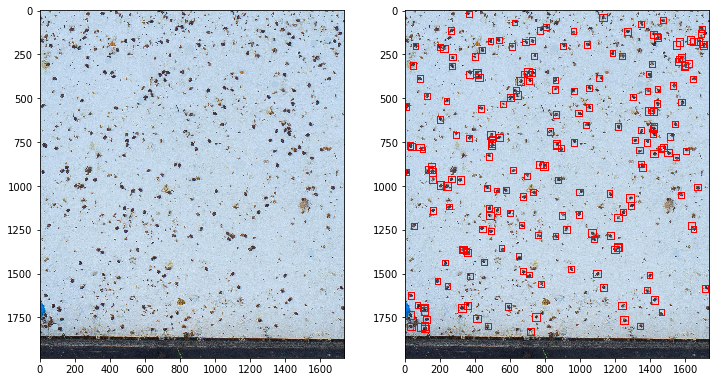

In [39]:
im_ind = 22
# res = test(ic_test[im_ind], model, model_yolo,0.9,0.2)
fig, ax = plt.subplots(1,2,figsize=(12,12))
for i in range(4):
    ax[0].imshow(ic_test[im_ind])
    ax[1].imshow(ic_test[im_ind])
    anno = annotations_xmls_test[im_ind]
    for num in anno:
        rect = patches.Rectangle((num['bbox'][0], num['bbox'][1]), num['bbox'][2], num['bbox'][3],
                    linewidth=1,edgecolor='r',facecolor='none')
        ax[1].add_patch(rect)

---

## Part 1: Finding varroas by segmentation

The pipeline of the segmentatoin method:

- Do image segmentation by the threshold we choose based on the histogram.
- Use the area as the criterion to detect the varroa.
- The threshold of the area is based on the area of the ground truth. 

In [682]:
def detect_by_segmentation(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    #pre-processing the image and normalize it.
    marker_threshold = (0.25,0.55)
    size_threshold = (400,1200)
    image = im_normalization(color.rgb2grey(img))
    
    #Define markers
    markers = np.zeros_like(image)
    markers[image < marker_threshold[0]] = 2
    markers[image > marker_threshold[1]] = 1
    
    #Generate elevation map
    elevation_map = sobel(image)
    
    #segment
    segmentation = watershed(elevation_map, markers)
    
    #fill the hole of image
    img_fill_holes = ndi.binary_fill_holes(segmentation == 2)
    label_objects, nb_labels = ndi.label(img_fill_holes)
    sizes = np.bincount(label_objects.ravel())
    
    # size constrain
    mask_sizes = np.logical_and(sizes > size_threshold[0],sizes<size_threshold[1])
    mask_sizes[0] = 0
    img_fill_holes = mask_sizes[label_objects]
    
    # shape constriant
    label_image = label(img_fill_holes)
    props = regionprops(label_image)
    len_c=[]
    len_r=[]
    diff=[]
    for i in props:
        tmp_c = i.bbox[3]-i.bbox[1]
        tmp_r = i.bbox[2]-i.bbox[0]
        len_c.append(tmp_c)
        len_r.append(tmp_r)
        diff.append(np.abs(tmp_c - tmp_r))
    median_c = np.median(np.array(len_c))
    median_r = np.median(np.array(len_r))
    median_diff = np.median(np.array(diff))
    
    count = 0;
    detect_area = [];
    
    for region in props:
    # take regions with large enough areas
        minr, minc, maxr, maxc = region.bbox
        if(np.abs((maxr-minr)-(maxc-minc))< 3*median_diff):
            count = count+1;
            detect_area.append(region.bbox)
    
    return detect_area, count

In [670]:
def im_normalization(img):
    return (img-np.min(img))/(np.max(img)-np.min(img))

In [7]:
def computeIOU(boxA, boxB):
    if(boxA[1] <= boxB[1]):
        minC = boxA[1]
        minIntersectC = boxB[1]
        maxIntersectC = boxA[3]
    else:
        minC = boxB[1]
        minIntersectC = boxA[1]
        maxIntersectC = boxB[3]
    
    if(boxA[0] <= boxB[0]):
        minR = boxA[0]
        minIntersectR = boxB[0]
        maxIntersectR = boxA[2]
    else:
        minR = boxB[0]
        minIntersectR = boxA[0]
        maxIntersectR = boxB[2]
    
    if(boxA[3]<boxB[3] and boxA[2]<boxB[2] and boxA[0]> boxB[0] and boxA[1]> boxB[1]):
        return ((boxA[2]-boxA[0]+1)*(boxA[3] - boxA[1]+1))/((boxB[2]-boxB[0]+1)*(boxB[3] - boxB[1]+1))
    if((boxB[3]<boxA[3] and boxB[2]<boxA[2] and boxB[0]> boxA[0] and boxB[1]> boxA[1])):
        return ((boxB[2]-boxB[0]+1)*(boxB[3] - boxB[1]+1))/((boxA[2]-boxA[0]+1)*(boxA[3] - boxA[1]+1))
    
    intersectArea =  max(0,(maxIntersectR - minIntersectR + 1))*max(0,maxIntersectC - minIntersectC + 1)
    
    unionArea = ((boxA[2]-boxA[0]+1)*(boxA[3] - boxA[1]+1) + (boxB[2]-boxB[0]+1)*(boxB[3] - boxB[1]+1) - intersectArea)
    
    return min(1,intersectArea/unionArea)

def NMS(test_windowsizes, prob_vector, prob_thres, iou_thres):
    
    # filter the sliding windows with the probability larger than 0.5 which are labeled as 'having varroa'
    prob_tuple = [(i,x) for i,x in enumerate(prob_vector) if x >= prob_thres]
    
    detect_tuple = []
    detect_windsize = []

    while(len(prob_tuple) != 0):

        # sort the probabilities
        sorted_prob_tuple = sorted(prob_tuple, key=lambda t:t[1], reverse=True)

        # find the sliding window with the largest probability as target
        target = sorted_prob_tuple[0]

        # save this target
        detect_tuple.append(target)
        target_windowsize = test_windowsizes[target[0]]

        # compute the iou between target and all the other sliding windows
        for tup in sorted_prob_tuple:
            iou = computeIOU(target_windowsize, test_windowsizes[tup[0]])
            # if iou is larger than the threshold, delete the corresponding sliding window
            if (iou >= iou_thres):
                prob_tuple.remove(tup)
    
    for t in detect_tuple:
        detect_windsize.append(test_windowsizes[t[0]])
    
    return detect_windsize

In [8]:
def find_MatchingBox(detect_box, groundTruth_list):
    candi = []
    IOU = []
    for j in groundTruth_list:
        maxC = max(detect_box[3],j[3])
        minC = min(detect_box[1],j[1])
        maxR = max(detect_box[2],j[2])
        minR = min(detect_box[0], j[0])
        boundC = (detect_box[3] - detect_box[1]) + (j[3] - j[1])
        boundR = (detect_box[2]-detect_box[0]) + (j[2] - j[0])
        if((maxC - minC) <= boundC and (maxR - minR) <= boundR):
            candi.append(j)
            IOU.append(computeIOU(detect_box,j))
            
    if(not IOU):
        iou_Value= 0
        return iou_Value, []
    
    iou_Value= max(IOU)
    index = IOU.index(iou_Value)
    return iou_Value,candi[index]

In [9]:
def compute_precision(tp, detect_num):
    if (tp!=0):
        return tp / detect_num
    else:
        return 0

In [10]:
def compute_recall(tp, groundTruth_num):
    if (tp!=0):
        return tp / groundTruth_num
    else:
        return 0

In [11]:
def compute_f1score(tp, detect_num, groundTruth_num):   
    prec = compute_precision(tp, detect_num)
    rec = compute_recall(tp, groundTruth_num)
    
    if((prec+rec)!=0):
        return (2*prec*rec)/(prec+rec)
    else:
        return 0

### implementation

Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [684]:
T_tp = []
detect_num_list = []
groundTruth_num = [] 
detect_area_list=[]

for ind in range(len(ic_test)):

    image = ic_test[ind]
    detect_area,detect_num = detect_by_segmentation(image)
    detect_area_list.append(detect_area)
    detect_num_list.append(detect_num)
    print('[{}]The number of varroa detected is {}.'.format(ind,detect_num))
    annotations = annotations_xmls_test[ind]
    groundTruth =[]

    for i in annotations:
        minC = i['bbox'][0]
        minR = i['bbox'][1]
        maxC = i['bbox'][2] + minC
        maxR = i['bbox'][3] + minR
        groundTruth.append((minR,minC,maxR,maxC))

    T_thres = []
    groundTruth_num.append(len(groundTruth))
    print("[{}]The number of ground truth is {}.".format(ind,len(groundTruth)))

    for i in range(len(detect_area)):

        iou_value,_ = find_MatchingBox(detect_area[i], groundTruth)
        if (iou_value >= 0.3):
            T_thres.append(i)

    T_tp.append(len(T_thres))
    print("[{}]The number of true positives is {}.".format(ind,len(T_thres)))

    precision = compute_precision(len(T_thres), detect_num)
    recall = compute_precision(len(T_thres), len(groundTruth))
    f1score = compute_f1score(len(T_thres), detect_num, len(groundTruth))
    print('[{}]When T=0.3, precision:{}, recall:{}, f1score:{}.'.format(ind,precision,recall,f1score))

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0]The number of varroa detected is 0.
[0]The number of ground truth is 0.
[0]The number of true positives is 0.
[0]When T=0.3, precision:0, recall:0, f1score:0.
[1]The number of varroa detected is 2.
[1]The number of ground truth is 0.
[1]The number of true positives is 0.
[1]When T=0.3, precision:0, recall:0, f1score:0.
[2]The number of varroa detected is 22.
[2]The number of ground truth is 18.
[2]The number of true positives is 17.
[2]When T=0.3, precision:0.7727272727272727, recall:0.9444444444444444, f1score:0.85.
[3]The number of varroa detected is 0.
[3]The number of ground truth is 0.
[3]The number of true positives is 0.
[3]When T=0.3, precision:0, recall:0, f1score:0.
[4]The number of varroa detected is 48.
[4]The number of ground truth is 20.
[4]The number of true positives is 1.
[4]When T=0.3, precision:0.020833333333333332, recall:0.05, f1score:0.029411764705882353.
[5]The number of varroa detected is 60.
[5]The number of ground truth is 3.
[5]The number of true positives

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


[19]The number of varroa detected is 0.
[19]The number of ground truth is 0.
[19]The number of true positives is 0.
[19]When T=0.3, precision:0, recall:0, f1score:0.
[20]The number of varroa detected is 135.
[20]The number of ground truth is 12.
[20]The number of true positives is 9.
[20]When T=0.3, precision:0.06666666666666667, recall:0.75, f1score:0.12244897959183675.
[21]The number of varroa detected is 1.
[21]The number of ground truth is 0.
[21]The number of true positives is 0.
[21]When T=0.3, precision:0, recall:0, f1score:0.
[22]The number of varroa detected is 29.
[22]The number of ground truth is 217.
[22]The number of true positives is 21.
[22]When T=0.3, precision:0.7241379310344828, recall:0.0967741935483871, f1score:0.17073170731707316.
[23]The number of varroa detected is 100.
[23]The number of ground truth is 16.
[23]The number of true positives is 13.
[23]When T=0.3, precision:0.13, recall:0.8125, f1score:0.22413793103448276.
[24]The number of varroa detected is 8.
[2

In [685]:
precision = compute_precision(sum(T_tp), sum(detect_num_list))
recall = compute_precision(sum(T_tp), sum(groundTruth_num))
f1score = compute_f1score(sum(T_tp), sum(detect_num_list), sum(groundTruth_num))
print('When T=0.3, precision:{}, recall:{}, f1score:{}.'.format(precision,recall,f1score))

When T=0.3, precision:0.23194562446898895, recall:0.4690721649484536, f1score:0.31040363843092666.


---

## Part 2: Implement your first detector

The pipeline of the PCA-Bayesian method:

- Use the sliding window to separate the original image into small parts.
- Label the positive and negative samples based on the iou between sliding windows and the ground truth.
- Use PCA to extract the most 10 important features of the training samples.
- Train the Naive Bayesian classifier.
- Use non-maximum supression 

### Train the Bayesian classifier

In [18]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            window_size = (y, x, y + windowSize[1], x + windowSize[0])
            yield (window_size, image[y:y + windowSize[1], x:x + windowSize[0],:])

Get the sliding windows of the image and label the sliding windows as positive ones and negative ones.

In [686]:
windowsizes_list = [] # save the window size and the location
windows_list = [] # save the windows
pos_windows = [] # save the positive samples
neg_windows = [] # save the negative samples

wind_size = 50
for ind in range(len(ic_train)):
    
    # get the sliding windows of each image and save the information of these sliding windows
    wind = sliding_window(ic_train[ind], 25, (wind_size,wind_size))
    windowsizes = []
    windows = []
    for w in wind:
        windowsizes.append(w[0])
        windows.append(w[1])
    
    windowsizes_list.append(windowsizes)
    windows_list.append(windows)
       
    # save the ground truth bounding box
    groundTruth = []
    
    for anno in annotations_xmls_train[ind]:
        minC = anno['bbox'][0]
        minR = anno['bbox'][1]
        maxC = anno['bbox'][2] + minC
        maxR = anno['bbox'][3] + minR
        groundTruth.append((minR,minC,maxR,maxC))
    
    iouvalues = []
    rest_pos_index = []
    pos_index = []
    # choose the positive sliding windows based on the iou of the groundtruth
    for j in range(len(windowsizes)):

        iou_value,_ = find_MatchingBox(windowsizes[j], groundTruth)
        
        if (iou_value >= 0.3):
            pos_gray_window = rgb2gray(windows[j])
            h,w = pos_gray_window.shape
            if ((h != wind_size) | (w != wind_size)):
                pos_gray_window = resize(pos_gray_window, (wind_size,wind_size), mode = 'constant')
            pos_windows.append(pos_gray_window)
            pos_index.append(j)
        if (iou_value == 0):
            rest_pos_index.append(j)
    
    # choose the negative sliding windows in the remain sliding windows
    num_pos = len(pos_index)
    choose = np.random.randint(len(rest_pos_index), size = num_pos)
    for i in range(len(choose)):
        neg_gray_window = rgb2gray(windows[rest_pos_index[choose[i]]])
        h,w = neg_gray_window.shape
        if ((h != wind_size) | (w != wind_size)):
            neg_gray_window = resize(neg_gray_window, (wind_size,wind_size), mode = 'constant')
        neg_windows.append(neg_gray_window)

In [696]:
print('The number of positive samples is {} and that of negative samples is {}.'.format(len(pos_windows),len(neg_windows)))

The number of positive samples is 12594 and that of negative samples is 12594.


Implement the PCA to extract the important features of the positive and negative sliding windows. 

In [697]:
def pca_mat(pos_im, neg_im):
    num_pos = len(pos_im)
    num_neg = len(neg_im)
    pos_mat = np.zeros((num_pos, wind_size * wind_size))
    neg_mat = np.zeros((num_neg, wind_size * wind_size))
    for i in range(num_pos):
        pos_mat[i,:] = pos_im[i].reshape(wind_size * wind_size,)
    
    for j in range(num_neg):            
        neg_mat[j,:] = neg_im[j].reshape(wind_size * wind_size,)
        
    decom_mat = np.vstack((pos_mat, neg_mat))
    
    return decom_mat

In [698]:
pca = PCA(n_components=10)
pca_model = pca.fit(pca_mat(pos_windows, neg_windows))
feature_mat = pca_model.transform(pca_mat(pos_windows, neg_windows))

In [699]:
pos_label = np.ones(len(pos_windows))
neg_label = np.zeros(len(neg_windows))
label = np.concatenate((pos_label,neg_label))

In [700]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
bayesian_classifier = gnb.fit(feature_mat, label, )

In [701]:
label_pred = bayesian_classifier.predict(feature_mat)
print("Number of mislabeled points out of a total %d points : %d" % (feature_mat.shape[0],(label != label_pred).sum()))

Number of mislabeled points out of a total 25188 points : 2259


The accuracy is 91% on the training set and we use this classifier to detect the sliding window containing varroa.

In [647]:
def detect_by_bayesian(img, prob_thres,iou_thres):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    # generate the sliding windows of the images
    wind = sliding_window(img, 15, (wind_size,wind_size))

    # save the sliding windows and corresponding locations
    test_windows = []
    test_windowsizes = []
    for w in wind:
        test_windowsizes.append(w[0])
        test_windows.append(rgb2gray(w[1]))

    # generate the matrix of the sliding windows in order to get features by PCA
    test_mat = np.zeros((len(test_windows), wind_size * wind_size))

    for i in range(len(test_windows)):
        gray_window = rgb2gray(test_windows[i])
        h,w = gray_window.shape
        if ((h != wind_size) | (w != wind_size)):
            gray_window = resize(gray_window, (wind_size,wind_size), mode = 'constant')
        
        test_mat[i,:] = gray_window.reshape(wind_size*wind_size,)
    
    # use PCA model to generate the test feature matrix
    test_feature_mat = pca_model.transform(test_mat)

    # use the Bayesian classifier to predict the probability of each sliding window
    test_windows_prob = bayesian_classifier.predict_proba(test_feature_mat)[:,1]
    
    detect_windsize = NMS(test_windowsizes, test_windows_prob, prob_thres, iou_thres)
    
    
    return detect_windsize

### implementation

Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [652]:
T_tp_list = []
detect_list = []
detect_windowsize_list = []
groundTruth_list = []

for ind in range(len(ic_test)):
    detect_windsize = detect_by_bayesian(ic_test[ind], 1-1e-4, 0.05)   
    print('[{}]The number of varroa detected is {}.'.format(ind,len(detect_windsize)))
    
    detect_list.append(len(detect_windsize))
    detect_windowsize_list.append(detect_windsize)
                          
    # get the locations of the ground truth
    groundTruth = []
    for anno in annotations_xmls_test[ind]:
        minC = anno['bbox'][0]
        minR = anno['bbox'][1]
        maxC = anno['bbox'][2] + minC
        maxR = anno['bbox'][3] + minR
        groundTruth.append((minR,minC,maxR,maxC))
    
    groundTruth_list.append(len(groundTruth))
    print('[{}]The number of ground truth is {}.'.format(ind,len(groundTruth)))

    # find the true positives
    T_tp = []
    for i in range(len(detect_windsize)):
        iou_value,_ = find_MatchingBox(detect_windsize[i], groundTruth)
        if (iou_value >= 0.3):
            T_tp.append(i)

    T_tp_list.append(len(T_tp))
    print("[{}]The number of true positives is {}.".format(ind,len(T_tp)))
    

    # calculate the precision, recall, f1score for each test image
    precision = compute_precision(len(T_tp), len(detect_windsize))
    recall = compute_precision(len(T_tp), len(groundTruth))
    f1score = compute_f1score(len(T_tp), len(detect_windsize), len(groundTruth))
    print('[{}]When T=0.3, precision:{}, recall:{}, f1score:{}.'.format(ind,precision,recall,f1score))

[0]The number of varroa detected is 0.
[0]The number of ground truth is 0.
[0]The number of true positives is 0.
[0]When T=0.3, precision:0, recall:0, f1score:0.
[1]The number of varroa detected is 47.
[1]The number of ground truth is 0.
[1]The number of true positives is 0.
[1]When T=0.3, precision:0, recall:0, f1score:0.
[2]The number of varroa detected is 18.
[2]The number of ground truth is 18.
[2]The number of true positives is 10.
[2]When T=0.3, precision:0.5555555555555556, recall:0.5555555555555556, f1score:0.5555555555555556.
[3]The number of varroa detected is 0.
[3]The number of ground truth is 0.
[3]The number of true positives is 0.
[3]When T=0.3, precision:0, recall:0, f1score:0.
[4]The number of varroa detected is 82.
[4]The number of ground truth is 20.
[4]The number of true positives is 4.
[4]When T=0.3, precision:0.04878048780487805, recall:0.2, f1score:0.07843137254901962.
[5]The number of varroa detected is 63.
[5]The number of ground truth is 3.
[5]The number of tr

[44]The number of varroa detected is 32.
[44]The number of ground truth is 6.
[44]The number of true positives is 3.
[44]When T=0.3, precision:0.09375, recall:0.5, f1score:0.15789473684210525.
[45]The number of varroa detected is 1.
[45]The number of ground truth is 1.
[45]The number of true positives is 0.
[45]When T=0.3, precision:0, recall:0, f1score:0.
[46]The number of varroa detected is 31.
[46]The number of ground truth is 1.
[46]The number of true positives is 1.
[46]When T=0.3, precision:0.03225806451612903, recall:1.0, f1score:0.0625.
[47]The number of varroa detected is 42.
[47]The number of ground truth is 11.
[47]The number of true positives is 8.
[47]When T=0.3, precision:0.19047619047619047, recall:0.7272727272727273, f1score:0.3018867924528302.
[48]The number of varroa detected is 25.
[48]The number of ground truth is 69.
[48]The number of true positives is 21.
[48]When T=0.3, precision:0.84, recall:0.30434782608695654, f1score:0.44680851063829796.
[49]The number of var

## Result of the Bayesian Classifier with PCA features

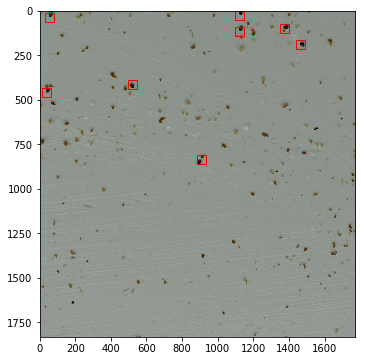

In [665]:
im_ind = 49
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(ic_test[im_ind])
annotations = detect_windowsize_list[im_ind]
annoT = []
for i in annotations: 
    annoT.append([i[1],i[0],i[3]-i[1],i[2]-i[0]])
    
for num in annoT:
    rect = patches.Rectangle((num[0], num[1]), num[2], num[3],
                linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

In [654]:
precision = compute_precision(sum(T_tp_list), sum(detect_list))
recall = compute_precision(sum(T_tp_list), sum(groundTruth_list))
f1score = compute_f1score(sum(T_tp_list), sum(detect_list), sum(groundTruth_list))
print('When T=0.3, precision:{}, recall:{}, f1score:{}.'.format(precision,recall,f1score))

When T=0.3, precision:0.14575471698113207, recall:0.5309278350515464, f1score:0.22871946706143598.


---

## Part 3: Using MLP and CNNs

Add your implementation for the thrid part. Feel free to add your desirable functions, but please make sure you have proper functions for the final detection, where their input and output follows the same format as the previous parts.

### Model 1: Using MLP + CNNs with Sobel filtered images

In [692]:
from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout,Add
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.objectives import categorical_crossentropy

from keras.models import Model
from keras.utils import generic_utils
from keras.engine import Layer, InputSpec
from keras import initializers, regularizers
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.initializers import glorot_uniform

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D

## Define the Model

In [704]:
from keras.optimizers import Adadelta
rows, cols = 50, 50
input_shape = (rows, cols, 3)
num_classes = 2
input1 = Input(shape=(rows,cols,3))
from keras.optimizers import Adadelta

# Resuidal block BN -> relu -> conv -> bn -> relu -> conv
def res_block(x, filters):
    bn1 = BatchNormalization()(x)
    act1 = Activation('relu')(bn1)
    conv1 = Conv2D(filters=filters, kernel_size=(3, 3), data_format='channels_first', strides=(2, 2), padding='same', 
                   kernel_initializer=glorot_uniform(seed=0))(act1)
    print('conv1.shape', conv1.shape)
    bn2 = BatchNormalization()(conv1)
    act2 = Activation('relu')(bn2)
    conv2 = Conv2D(filters=filters, kernel_size=(3, 3), data_format='channels_first', strides=(1, 1), padding='same', 
                   kernel_initializer=glorot_uniform(seed=0))(act2)
    print('conv2.shape', conv2.shape)
    residual = Conv2D(1, (1, 1), strides=(1, 1), data_format='channels_first')(conv2)
    
    
    x = Conv2D(filters=filters, kernel_size=(3, 3), data_format='channels_first', strides=(2, 2), padding='same', 
                   kernel_initializer=glorot_uniform(seed=0))(x)
    print('x.shape', x.shape)
    out = Add()([x, residual])
    
    return out

res1 = res_block(input1, 64)
res2 = res_block(res1, 128)
res3 = res_block(res2, 256)
res4 = res_block(res3, 512)

act1 = Activation('relu')(res4)
flatten1 = Flatten()(act1)
dense1 = Dense(512)(flatten1)
act2 = Activation('relu')(dense1)
dense2 = Dense(num_classes)(act2)
output1 = Activation('softmax')(dense2)

model3 = Model(inputs=input1, outputs=output1)

model3.compile(loss='categorical_crossentropy',
               optimizer= Adadelta(lr=0.01),
              metrics=['accuracy'])

model3.summary()

conv1.shape (?, 64, 25, 2)
conv2.shape (?, 64, 25, 2)
x.shape (?, 64, 25, 2)
conv1.shape (?, 128, 13, 1)
conv2.shape (?, 128, 13, 1)
x.shape (?, 128, 13, 1)
conv1.shape (?, 256, 7, 1)
conv2.shape (?, 256, 7, 1)
x.shape (?, 256, 7, 1)
conv1.shape (?, 512, 4, 1)
conv2.shape (?, 512, 4, 1)
x.shape (?, 512, 4, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 50, 50, 3)    12          input_4[0][0]                    
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 50, 50, 3)    0           batch_normalization_10[0][0]  

In [716]:
import keras
import keras_resnet.models
shape,classes = (50,50,1),2
x = keras.layers.Input(shape)
model5 = keras_resnet.models.ResNet50(x,classes = classes)
model5.compile("adam", "categorical_crossentropy", ["accuracy"])


In [717]:
model5.load_weights('sobel.h5')

### Test on the test sets

In [29]:
T_tp_list = []
detect_list = []
detect_windowsize_list = []
groundTruth_list = []

for ind in range(len(ic_test)):
    
    detect_windsize = []
    for i in range(0,ic_test[ind].shape[0]-50,50):
        for j in range(0,ic_test[ind].shape[1]-50,50):
            crop = ic_test[ind][i:i+50,j:j+50,:]
            crop = skimage.filters.sobel(color.rgb2gray(crop))
            prediction = model5.predict(crop.reshape((1,50,50,1)))
            pred = np.argmax(prediction[0])
            if pred > 0.9:
                detect_windsize.append([i,j,i+50,j+50])
    
    print('[{}]The number of varroa detected is {}.'.format(ind,len(detect_windsize)))
    
    detect_list.append(len(detect_windsize))
    detect_windowsize_list.append(detect_windsize)
                          
    # get the locations of the ground truth
    groundTruth = []
    for anno in annotations_xmls_test[ind]:
        minC = anno['bbox'][0]
        minR = anno['bbox'][1]
        maxC = anno['bbox'][2] + minC
        maxR = anno['bbox'][3] + minR
        groundTruth.append((minR,minC,maxR,maxC))
    
    groundTruth_list.append(len(groundTruth))
    print('[{}]The number of ground truth is {}.'.format(ind,len(groundTruth)))

    # find the true positives
    T_tp = []
    for i in range(len(detect_windsize)):
        iou_value,_ = find_MatchingBox(detect_windsize[i], groundTruth)
        if (iou_value >= 0.3):
            T_tp.append(i)

    T_tp_list.append(len(T_tp))
    print("[{}]The number of true positives is {}.".format(ind,len(T_tp)))
    

    # calculate the precision, recall, f1score for each test image
    precision = compute_precision(len(T_tp), len(detect_windsize))
    recall = compute_precision(len(T_tp), len(groundTruth))
    f1score = compute_f1score(len(T_tp), len(detect_windsize), len(groundTruth))
    print('[{}]When T=0.3, precision:{}, recall:{}, f1score:{}.'.format(ind,precision,recall,f1score))

In [40]:
precision = compute_precision(sum(T_tp_list), sum(detect_list))
recall = compute_precision(sum(T_tp_list), sum(groundTruth_list))
f1score = compute_f1score(sum(T_tp_list), sum(detect_list), sum(groundTruth_list))
print('When T=0.3, precision:{}, recall:{}, f1score:{}.'.format(precision,recall,f1score))

# Model 2:  FlyNet: ResNet50 + Yolo Layers

In [12]:
from __future__ import division
import os
import sys
import time
import datetime
import argparse

from PIL import Image

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import math
import time
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"]="2"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Parser function

In [13]:
def parse_model_config(path):
    """Parses the yolo-v3 layer configuration file and returns module definitions"""
    file = open(path, 'r')
    lines = file.read().split('\n')
    lines = [x for x in lines if x and not x.startswith('#')]
    lines = [x.rstrip().lstrip() for x in lines] # get rid of fringe whitespaces
    module_defs = []
    for line in lines:
        if line.startswith('['): # This marks the start of a new block
            module_defs.append({})
            module_defs[-1]['type'] = line[1:-1].rstrip()
            if module_defs[-1]['type'] == 'convolutional':
                module_defs[-1]['batch_normalize'] = 0
        else:
            key, value = line.split("=")
            value = value.strip()
            module_defs[-1][key.rstrip()] = value.strip()

    return module_defs

def parse_data_config(path):
    """Parses the data configuration file"""
    options = dict()
    options['gpus'] = '0,1,2,3'
    options['num_workers'] = '10'
    with open(path, 'r') as fp:
        lines = fp.readlines()
    for line in lines:
        line = line.strip()
        if line == '' or line.startswith('#'):
            continue
        key, value = line.split('=')
        options[key.strip()] = value.strip()
    return options

## Create Yolo Layers

In [14]:
def create_modules(module_defs):
    """
    Constructs module list of layer blocks from module configuration in module_defs
    """
    hyperparams = module_defs.pop(0)
    output_filters = [int(hyperparams["channels"])]
    module_list = nn.ModuleList()
    for module_i, module_def in enumerate(module_defs):
        modules = nn.Sequential()

        if module_def["type"] == "convolutional":
            bn = int(module_def["batch_normalize"])
            filters = int(module_def["filters"])
            kernel_size = int(module_def["size"])
            pad = (kernel_size - 1) // 2
            modules.add_module(
                f"conv_{module_i}",
                nn.Conv2d(
                    in_channels=output_filters[-1],
                    out_channels=filters,
                    kernel_size=kernel_size,
                    stride=int(module_def["stride"]),
                    padding=pad,
                    bias=not bn,
                ),
            )
            if bn:
                modules.add_module(f"batch_norm_{module_i}", nn.BatchNorm2d(filters, momentum=0.9, eps=1e-5))
            if module_def["activation"] == "leaky":
                modules.add_module(f"leaky_{module_i}", nn.LeakyReLU(0.1))

        elif module_def["type"] == "maxpool":
            kernel_size = int(module_def["size"])
            stride = int(module_def["stride"])
            if kernel_size == 2 and stride == 1:
                modules.add_module(f"_debug_padding_{module_i}", nn.ZeroPad2d((0, 1, 0, 1)))
            maxpool = nn.MaxPool2d(kernel_size=kernel_size, stride=stride, padding=int((kernel_size - 1) // 2))
            modules.add_module(f"maxpool_{module_i}", maxpool)

        elif module_def["type"] == "upsample":
            upsample = Upsample(scale_factor=int(module_def["stride"]), mode="nearest")
            modules.add_module(f"upsample_{module_i}", upsample)

        elif module_def["type"] == "route":
            layers = [int(x) for x in module_def["layers"].split(",")]
            filters = sum([output_filters[1:][i] for i in layers])
            modules.add_module(f"route_{module_i}", EmptyLayer())

        elif module_def["type"] == "shortcut":
            filters = output_filters[1:][int(module_def["from"])]
            modules.add_module(f"shortcut_{module_i}", EmptyLayer())

        elif module_def["type"] == "yolo":
            anchor_idxs = [int(x) for x in module_def["mask"].split(",")]
            # Extract anchors
            anchors = [int(x) for x in module_def["anchors"].split(",")]
            anchors = [(anchors[i], anchors[i + 1]) for i in range(0, len(anchors), 2)]
            anchors = [anchors[i] for i in anchor_idxs]
            num_classes = int(module_def["classes"])
            img_size = int(hyperparams["height"])
            # Define detection layer
            yolo_layer = YOLOLayer(anchors, num_classes, img_size)
            modules.add_module(f"yolo_{module_i}", yolo_layer)
        # Register module list and number of output filters
        module_list.append(modules)
        output_filters.append(filters)

    return hyperparams, module_list


class Upsample(nn.Module):
    """ nn.Upsample is deprecated """

    def __init__(self, scale_factor, mode="nearest"):
        super(Upsample, self).__init__()
        self.scale_factor = scale_factor
        self.mode = mode

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        return x


class EmptyLayer(nn.Module):
    """Placeholder for 'route' and 'shortcut' layers"""

    def __init__(self):
        super(EmptyLayer, self).__init__()


class YOLOLayer(nn.Module):
    """Detection layer"""

    def __init__(self, anchors, num_classes, img_dim=416):
        super(YOLOLayer, self).__init__()
        self.anchors = anchors
        self.num_anchors = len(anchors)
        self.num_classes = num_classes
        self.ignore_thres = 0.5
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCELoss()
        self.obj_scale = 1
        self.noobj_scale = 1
        self.metrics = {}
        self.img_dim = img_dim
        self.grid_size = 0  # grid size

    def compute_grid_offsets(self, grid_size, cuda=True):
        self.grid_size = grid_size
        g = self.grid_size
        FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
        self.stride = self.img_dim / self.grid_size
        # Calculate offsets for each grid
        self.grid_x = torch.arange(g).repeat(g, 1).view([1, 1, g, g]).type(FloatTensor)
        self.grid_y = torch.arange(g).repeat(g, 1).t().view([1, 1, g, g]).type(FloatTensor)
        self.scaled_anchors = FloatTensor([(a_w / self.stride, a_h / self.stride) for a_w, a_h in self.anchors])
        self.anchor_w = self.scaled_anchors[:, 0:1].view((1, self.num_anchors, 1, 1))
        self.anchor_h = self.scaled_anchors[:, 1:2].view((1, self.num_anchors, 1, 1))

    def forward(self, x, targets=None, img_dim=None):

        # Tensors for cuda support
        FloatTensor = torch.cuda.FloatTensor if x.is_cuda else torch.FloatTensor
        LongTensor = torch.cuda.LongTensor if x.is_cuda else torch.LongTensor
        ByteTensor = torch.cuda.ByteTensor if x.is_cuda else torch.ByteTensor

        self.img_dim = img_dim
        num_samples = x.size(0)
        grid_size = x.size(2)

        prediction = (
            x.view(num_samples, self.num_anchors, self.num_classes + 5, grid_size, grid_size)
            .permute(0, 1, 3, 4, 2)
            .contiguous()
        )

        # Get outputs
        x = torch.sigmoid(prediction[..., 0])  # Center x
        y = torch.sigmoid(prediction[..., 1])  # Center y
        w = prediction[..., 2]  # Width
        h = prediction[..., 3]  # Height
        pred_conf = torch.sigmoid(prediction[..., 4])  # Conf
        pred_cls = torch.sigmoid(prediction[..., 5:])  # Cls pred.

        # If grid size does not match current we compute new offsets
        if grid_size != self.grid_size:
            self.compute_grid_offsets(grid_size, cuda=x.is_cuda)

        # Add offset and scale with anchors
        pred_boxes = FloatTensor(prediction[..., :4].shape)
        pred_boxes[..., 0] = x.data + self.grid_x
        pred_boxes[..., 1] = y.data + self.grid_y
        pred_boxes[..., 2] = torch.exp(w.data) * self.anchor_w
        pred_boxes[..., 3] = torch.exp(h.data) * self.anchor_h

        output = torch.cat(
            (
                pred_boxes.view(num_samples, -1, 4) * self.stride,
                pred_conf.view(num_samples, -1, 1),
                pred_cls.view(num_samples, -1, self.num_classes),
            ),
            -1,
        )

        if targets is None:
            
            total_loss = self.bce_loss(pred_conf, torch.zeros_like(pred_conf))
            
            return output, total_loss
        else:
            iou_scores, class_mask, obj_mask, noobj_mask, tx, ty, tw, th, tcls, tconf = build_targets(
                pred_boxes=pred_boxes,
                pred_cls=pred_cls,
                target=targets,
                anchors=self.scaled_anchors,
                ignore_thres=self.ignore_thres,
            )

            # Loss : Mask outputs to ignore non-existing objects (except with conf. loss)
            loss_x = self.mse_loss(x[obj_mask], tx[obj_mask])
            loss_y = self.mse_loss(y[obj_mask], ty[obj_mask])
            loss_w = self.mse_loss(w[obj_mask], tw[obj_mask])
            loss_h = self.mse_loss(h[obj_mask], th[obj_mask])
            loss_conf_obj = self.bce_loss(pred_conf[obj_mask], tconf[obj_mask])
            loss_conf_noobj = self.bce_loss(pred_conf[noobj_mask], tconf[noobj_mask])
            loss_conf = self.obj_scale * loss_conf_obj + self.noobj_scale * loss_conf_noobj
            loss_cls = self.bce_loss(pred_cls[obj_mask], tcls[obj_mask])
            total_loss = loss_x + loss_y + loss_w + loss_h + loss_conf + loss_cls

            # Metrics
            cls_acc = 100 * class_mask[obj_mask].mean()
            conf_obj = pred_conf[obj_mask].mean()
            conf_noobj = pred_conf[noobj_mask].mean()
            conf50 = (pred_conf > 0.5).float()
            iou50 = (iou_scores > 0.5).float()
            iou75 = (iou_scores > 0.75).float()
            detected_mask = conf50 * class_mask * tconf
            precision = torch.sum(iou50 * detected_mask) / (conf50.sum() + 1e-16)
            recall50 = torch.sum(iou50 * detected_mask) / (obj_mask.sum() + 1e-16)
            recall75 = torch.sum(iou75 * detected_mask) / (obj_mask.sum() + 1e-16)

            self.metrics = {
                "loss": to_cpu(total_loss).item(),
                "x": to_cpu(loss_x).item(),
                "y": to_cpu(loss_y).item(),
                "w": to_cpu(loss_w).item(),
                "h": to_cpu(loss_h).item(),
                "conf": to_cpu(loss_conf).item(),
                "cls": to_cpu(loss_cls).item(),
                "cls_acc": to_cpu(cls_acc).item(),
                "recall50": to_cpu(recall50).item(),
                "recall75": to_cpu(recall75).item(),
                "precision": to_cpu(precision).item(),
                "conf_obj": to_cpu(conf_obj).item(),
                "conf_noobj": to_cpu(conf_noobj).item(),
                "grid_size": grid_size,
            }

            return output, total_loss


class Darknet(nn.Module):
    """YOLOv3 object detection model"""

    def __init__(self, config_path, img_size=416):
        super(Darknet, self).__init__()
        self.module_defs = parse_model_config(config_path)
        self.hyperparams, self.module_list = create_modules(self.module_defs)
        self.yolo_layers = [layer[0] for layer in self.module_list if hasattr(layer[0], "metrics")]
        self.img_size = img_size
        self.seen = 0
        self.header_info = np.array([0, 0, 0, self.seen, 0], dtype=np.int32)

    def forward(self, x, targets=None):
        img_dim = x.shape[2]
        loss = 0
        layer_outputs, yolo_outputs = [], []
        for i, (module_def, module) in enumerate(zip(self.module_defs, self.module_list)):
            if module_def["type"] in ["convolutional", "upsample", "maxpool"]:
                x = module(x)
            elif module_def["type"] == "route":
                x = torch.cat([layer_outputs[int(layer_i)] for layer_i in module_def["layers"].split(",")], 1)
            elif module_def["type"] == "shortcut":
                layer_i = int(module_def["from"])
                x = layer_outputs[-1] + layer_outputs[layer_i]
            elif module_def["type"] == "yolo":
                x, layer_loss = module[0](x, targets, img_dim)
                loss += layer_loss
                yolo_outputs.append(x)
            layer_outputs.append(x)
        yolo_outputs = to_cpu(torch.cat(yolo_outputs, 1))
#         return yolo_outputs if targets is None else (loss, yolo_outputs)
        return (loss, yolo_outputs)

    def load_darknet_weights(self, weights_path):
        """Parses and loads the weights stored in 'weights_path'"""

        # Open the weights file
        with open(weights_path, "rb") as f:
            header = np.fromfile(f, dtype=np.int32, count=5)  # First five are header values
            self.header_info = header  # Needed to write header when saving weights
            self.seen = header[3]  # number of images seen during training
            weights = np.fromfile(f, dtype=np.float32)  # The rest are weights

        # Establish cutoff for loading backbone weights
        cutoff = None
        if "darknet53.conv.74" in weights_path:
            cutoff = 75

        ptr = 0
        for i, (module_def, module) in enumerate(zip(self.module_defs, self.module_list)):
            if i == cutoff:
                break
            if module_def["type"] == "convolutional":
                conv_layer = module[0]
                if module_def["batch_normalize"]:
                    # Load BN bias, weights, running mean and running variance
                    bn_layer = module[1]
                    num_b = bn_layer.bias.numel()  # Number of biases
                    # Bias
                    bn_b = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.bias)
                    bn_layer.bias.data.copy_(bn_b)
                    ptr += num_b
                    # Weight
                    bn_w = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.weight)
                    bn_layer.weight.data.copy_(bn_w)
                    ptr += num_b
                    # Running Mean
                    bn_rm = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.running_mean)
                    bn_layer.running_mean.data.copy_(bn_rm)
                    ptr += num_b
                    # Running Var
                    bn_rv = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.running_var)
                    bn_layer.running_var.data.copy_(bn_rv)
                    ptr += num_b
                else:
                    # Load conv. bias
                    num_b = conv_layer.bias.numel()
                    conv_b = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(conv_layer.bias)
                    conv_layer.bias.data.copy_(conv_b)
                    ptr += num_b
                # Load conv. weights
                num_w = conv_layer.weight.numel()
                conv_w = torch.from_numpy(weights[ptr : ptr + num_w]).view_as(conv_layer.weight)
                conv_layer.weight.data.copy_(conv_w)
                ptr += num_w

    def save_darknet_weights(self, path, cutoff=-1):
        """
            @:param path    - path of the new weights file
            @:param cutoff  - save layers between 0 and cutoff (cutoff = -1 -> all are saved)
        """
        fp = open(path, "wb")
        self.header_info[3] = self.seen
        self.header_info.tofile(fp)

        # Iterate through layers
        for i, (module_def, module) in enumerate(zip(self.module_defs[:cutoff], self.module_list[:cutoff])):
            if module_def["type"] == "convolutional":
                conv_layer = module[0]
                # If batch norm, load bn first
                if module_def["batch_normalize"]:
                    bn_layer = module[1]
                    bn_layer.bias.data.cpu().numpy().tofile(fp)
                    bn_layer.weight.data.cpu().numpy().tofile(fp)
                    bn_layer.running_mean.data.cpu().numpy().tofile(fp)
                    bn_layer.running_var.data.cpu().numpy().tofile(fp)
                # Load conv bias
                else:
                    conv_layer.bias.data.cpu().numpy().tofile(fp)
                # Load conv weights
                conv_layer.weight.data.cpu().numpy().tofile(fp)

        fp.close()

## The utils function to compute the AP and perform Non-max-suppresion

In [15]:
def to_cpu(tensor):
    return tensor.detach().cpu()


def load_classes(path):
    """
    Loads class labels at 'path'
    """
    fp = open(path, "r")
    names = fp.read().split("\n")[:-1]
    return names


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


def rescale_boxes(boxes, current_dim, original_shape):
    """ Rescales bounding boxes to the original shape """
    orig_h, orig_w = original_shape
    # The amount of padding that was added
    pad_x = max(orig_h - orig_w, 0) * (current_dim / max(original_shape))
    pad_y = max(orig_w - orig_h, 0) * (current_dim / max(original_shape))
    # Image height and width after padding is removed
    unpad_h = current_dim - pad_y
    unpad_w = current_dim - pad_x
    # Rescale bounding boxes to dimension of original image
    boxes[:, 0] = ((boxes[:, 0] - pad_x // 2) / unpad_w) * orig_w
    boxes[:, 1] = ((boxes[:, 1] - pad_y // 2) / unpad_h) * orig_h
    boxes[:, 2] = ((boxes[:, 2] - pad_x // 2) / unpad_w) * orig_w
    boxes[:, 3] = ((boxes[:, 3] - pad_y // 2) / unpad_h) * orig_h
    return boxes


def xywh2xyxy(x):
    y = x.new(x.shape)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y


def ap_per_class(tp, conf, pred_cls, target_cls):
    """ Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rafaelpadilla/Object-Detection-Metrics.
    # Arguments
        tp:    True positives (list).
        conf:  Objectness value from 0-1 (list).
        pred_cls: Predicted object classes (list).
        target_cls: True object classes (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """

    # Sort by objectness
    i = np.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes = np.unique(target_cls)

    # Create Precision-Recall curve and compute AP for each class
    ap, p, r = [], [], []
    for c in tqdm.tqdm(unique_classes, desc="Computing AP"):
        i = pred_cls == c
        n_gt = (target_cls == c).sum()  # Number of ground truth objects
        n_p = i.sum()  # Number of predicted objects

        if n_p == 0 and n_gt == 0:
            continue
        elif n_p == 0 or n_gt == 0:
            ap.append(0)
            r.append(0)
            p.append(0)
        else:
            # Accumulate FPs and TPs
            fpc = (1 - tp[i]).cumsum()
            tpc = (tp[i]).cumsum()

            # Recall
            recall_curve = tpc / (n_gt + 1e-16)
            r.append(recall_curve[-1])

            # Precision
            precision_curve = tpc / (tpc + fpc)
            p.append(precision_curve[-1])

            # AP from recall-precision curve
            ap.append(compute_ap(recall_curve, precision_curve))

    # Compute F1 score (harmonic mean of precision and recall)
    p, r, ap = np.array(p), np.array(r), np.array(ap)
    f1 = 2 * p * r / (p + r + 1e-16)

    return p, r, ap, f1, unique_classes.astype("int32")


def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.

    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap


def get_batch_statistics(outputs, targets, iou_threshold):
    """ Compute true positives, predicted scores and predicted labels per sample """
    batch_metrics = []
    for sample_i in range(len(outputs)):

        if outputs[sample_i] is None:
            continue

        output = outputs[sample_i]
        pred_boxes = output[:, :4]
        pred_scores = output[:, 4]
        pred_labels = output[:, -1]

        true_positives = np.zeros(pred_boxes.shape[0])

        annotations = targets[targets[:, 0] == sample_i][:, 1:]
        target_labels = annotations[:, 0] if len(annotations) else []
        if len(annotations):
            detected_boxes = []
            target_boxes = annotations[:, 1:]

            for pred_i, (pred_box, pred_label) in enumerate(zip(pred_boxes, pred_labels)):

                # If targets are found break
                if len(detected_boxes) == len(annotations):
                    break

                # Ignore if label is not one of the target labels
                if pred_label not in target_labels:
                    continue

                iou, box_index = bbox_iou(pred_box.unsqueeze(0), target_boxes).max(0)
                if iou >= iou_threshold and box_index not in detected_boxes:
                    true_positives[pred_i] = 1
                    detected_boxes += [box_index]
        batch_metrics.append([true_positives, pred_scores, pred_labels])
    return batch_metrics


def bbox_wh_iou(wh1, wh2):
    wh2 = wh2.t()
    w1, h1 = wh1[0], wh1[1]
    w2, h2 = wh2[0], wh2[1]
    inter_area = torch.min(w1, w2) * torch.min(h1, h2)
    union_area = (w1 * h1 + 1e-16) + w2 * h2 - inter_area
    return inter_area / union_area


def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(
        inter_rect_y2 - inter_rect_y1 + 1, min=0
    )
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou


def non_max_suppression(prediction, conf_thres=0.5, nms_thres=0.4):
    """
    Removes detections with lower object confidence score than 'conf_thres' and performs
    Non-Maximum Suppression to further filter detections.
    Returns detections with shape:
        (x1, y1, x2, y2, object_conf, class_score, class_pred)
    """

    # From (center x, center y, width, height) to (x1, y1, x2, y2)
    prediction[..., :4] = xywh2xyxy(prediction[..., :4])
    output = [None for _ in range(len(prediction))]
    for image_i, image_pred in enumerate(prediction):
        # Filter out confidence scores below threshold
        image_pred = image_pred[image_pred[:, 4] >= conf_thres]
        # If none are remaining => process next image
        if not image_pred.size(0):
            continue
        # Object confidence times class confidence
        score = image_pred[:, 4] * image_pred[:, 5:].max(1)[0]
        # Sort by it
        image_pred = image_pred[np.argsort((-score).numpy())]
        class_confs, class_preds = image_pred[:, 5:].max(1, keepdim=True)
        detections = torch.cat((image_pred[:, :5], class_confs.float(), class_preds.float()), 1)
        # Perform non-maximum suppression
        keep_boxes = []
        while detections.size(0):
            large_overlap = bbox_iou(detections[0, :4].unsqueeze(0), detections[:, :4]) > nms_thres
            label_match = detections[0, -1] == detections[:, -1]
            # Indices of boxes with lower confidence scores, large IOUs and matching labels
            invalid = large_overlap & label_match
            weights = detections[invalid, 4:5]
            # Merge overlapping bboxes by order of confidence
            detections[0, :4] = (weights * detections[invalid, :4]).sum(0) / weights.sum()
            keep_boxes += [detections[0]]
            detections = detections[~invalid]
        if keep_boxes:
            output[image_i] = torch.stack(keep_boxes)

    return output


def build_targets(pred_boxes, pred_cls, target, anchors, ignore_thres):

    ByteTensor = torch.cuda.ByteTensor if pred_boxes.is_cuda else torch.ByteTensor
    FloatTensor = torch.cuda.FloatTensor if pred_boxes.is_cuda else torch.FloatTensor

    nB = pred_boxes.size(0)
    nA = pred_boxes.size(1)
    nC = pred_cls.size(-1)
    nG = pred_boxes.size(2)

    # Output tensors
    obj_mask = ByteTensor(nB, nA, nG, nG).fill_(0)
    noobj_mask = ByteTensor(nB, nA, nG, nG).fill_(1)
    class_mask = FloatTensor(nB, nA, nG, nG).fill_(0)
    iou_scores = FloatTensor(nB, nA, nG, nG).fill_(0)
    tx = FloatTensor(nB, nA, nG, nG).fill_(0)
    ty = FloatTensor(nB, nA, nG, nG).fill_(0)
    tw = FloatTensor(nB, nA, nG, nG).fill_(0)
    th = FloatTensor(nB, nA, nG, nG).fill_(0)
    tcls = FloatTensor(nB, nA, nG, nG, nC).fill_(0)

    # Convert to position relative to box
    target_boxes = target[:, 2:6] * nG
    gxy = target_boxes[:, :2]
    gwh = target_boxes[:, 2:]
    # Get anchors with best iou
    ious = torch.stack([bbox_wh_iou(anchor, gwh) for anchor in anchors])
    best_ious, best_n = ious.max(0)
    # Separate target values
    b, target_labels = target[:, :2].long().t()
    gx, gy = gxy.t()
    gw, gh = gwh.t()
    gi, gj = gxy.long().t()
    # Set masks
    obj_mask[b, best_n, gj, gi] = 1
    noobj_mask[b, best_n, gj, gi] = 0

    # Set noobj mask to zero where iou exceeds ignore threshold
    for i, anchor_ious in enumerate(ious.t()):
        noobj_mask[b[i], anchor_ious > ignore_thres, gj[i], gi[i]] = 0

    # Coordinates
    tx[b, best_n, gj, gi] = gx - gx.floor()
    ty[b, best_n, gj, gi] = gy - gy.floor()
    # Width and height
    tw[b, best_n, gj, gi] = torch.log(gw / anchors[best_n][:, 0] + 1e-16)
    th[b, best_n, gj, gi] = torch.log(gh / anchors[best_n][:, 1] + 1e-16)
    # One-hot encoding of label
    tcls[b, best_n, gj, gi, target_labels] = 1
    # Compute label correctness and iou at best anchor
    class_mask[b, best_n, gj, gi] = (pred_cls[b, best_n, gj, gi].argmax(-1) == target_labels).float()
    iou_scores[b, best_n, gj, gi] = bbox_iou(pred_boxes[b, best_n, gj, gi], target_boxes, x1y1x2y2=False)

    tconf = obj_mask.float()
    return iou_scores, class_mask, obj_mask, noobj_mask, tx, ty, tw, th, tcls, tconf

## Create the FlyNet Model and Load the weights

In [19]:
import keras
import keras_resnet.models
from keras.layers import Input

model_yolo = Darknet('./yolov3-custom.cfg', img_size = 416).to(device)
model_yolo.load_state_dict(torch.load('./yolofly_ckpt_1.pth'))
shape,classes = (416,416,3),2
x = keras.layers.Input(shape)
model_classification = keras_resnet.models.ResNet50(x,classes = classes)
model_classification.load_weights('./yolo.h5')

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


# Test functions

In [21]:
def annoTransfer(medianBbox):
    '''
    input: medianBbox: [medianR,medianC,H,W]
    output: upperLeftBbox: [minC,minR,W,H]
    '''
    medianR = medianBbox[0]
    medianC = medianBbox[1]
    H = medianBbox[2]
    W = medianBbox[3]
    minC = int(medianC - W/2)
    minR = int(medianR - H/2)
    
    return [minC,minR,W,H]


def findBoundingBox(upperLeftRC, size, annoList):
    '''
    upperLeftRC: upperLeft corodinate of of the side window:(row, clomn) 
    size: the size of the side window: (h,w)
    annoList: the annotations for the orignial image
    
    '''
    r,c = upperLeftRC
    h,w = size
    bbox = []
    for i in annoList:
        minC = i['bbox'][0]
        minR = i['bbox'][1]
        maxC = i['bbox'][2] + minC
        maxR = i['bbox'][3] + minR
        iou = computeIOU((r,c,r+h,c+w),(minR,minC,maxR,maxC))
        if iou>0:
            meddle = (np.round(minR+(maxR-minR)/2),np.round(minC + (maxC - minC)/2))
            if r <= meddle[0] < r+h:
                if c<= meddle[1] < c+w:
                    # [row, clomun, sizeH, sizeW]
                    bbox.append([meddle[0]-r, meddle[1]-c, i['bbox'][3], i['bbox'][2]])
    return bbox


def singleImgSplit(subSize, stride, resize, img, annotation):
    '''
    subSize: the patch size (h,w)
    stride: the stride
    img: the original image
    resize: resize = (h,w) the size you want right
    '''
    if resize !=  0:
        resizedImg = cv2.resize(img,resize)
    else:
        resizedImg = img
        
    H, W, _ = resizedImg.shape
    
    # NH,NW is how many images we should have in each dimension
    NH = np.ceil((H-subSize)/stride) + 1
    NW = np.ceil((W-subSize)/stride) + 1
    
    paddingH = stride*(NH - 1) - H + subSize 
    paddingW = stride*(NW - 1) - W + subSize
    
    #padding the image
    if paddingH != 0:
        resizedImg = np.pad(resizedImg, ((0,int(paddingH)),(0,0),(0,0)), 'constant')
    if paddingW != 0:
        resizedImg = np.pad(resizedImg, ((0,0),(0, int(paddingW)),(0,0)), 'constant')
    
    Hp, Wp, _ = resizedImg.shape
    output = []
    index = 0
    up = 0
    
    while((up + subSize)<= Hp):
        left = 0
        while((left + subSize) <= Wp):
            
            outputDict = {}
            patchImg = resizedImg[up:(up+subSize), left:(left+subSize)]
            annoList = findBoundingBox((up,left),(subSize,subSize),annotation)
        
            outputDict['img'] = patchImg 
            outputDict['bbox'] = annoList
            outputDict['rc'] = [up,left]
            output.append(outputDict)
            index+=1
            left = left + stride
        up = up + stride
        
    return output

In [22]:
def transfer_anno(detections, upperleft_rc):
    res = []
    for i in range(detections.shape[0]):
        x = detections[i,1] + upperleft_rc[1]
        y = detections[i,0] + upperleft_rc[0]
        w = detections[i,3]-detections[i,1]
        h = detections[i,2]-detections[i,0]
        obj_conf = detections[i,4]
        res.append([x,y,w,h,obj_conf])
    return res
def test(img, model_classification, model_yolo, nms_conf, iou_conf):
    output = singleImgSplit(416, 416, 0,img,[])
    res = []
    for i in range(len(output)):
        isfly = model_classification.predict(output[i]['img'][np.newaxis,...])[:,1] >0.95
        if isfly:
            Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
            input_imgs = torch.Tensor(np.transpose(output[i]['img'],(2,0,1))[np.newaxis,...])
            input_imgs = Variable(input_imgs.type(Tensor))
            with torch.no_grad():
                detections = model_yolo(input_imgs)
                detections = non_max_suppression(detections[1], nms_conf, iou_conf)
                if type(detections[0])!=type(None):
                    annoT = transfer_anno(detections=detections[0], upperleft_rc=output[i]['rc'])
                res.append(annoT)
    final_res =[]
    for i in range(len(res)):
        for j in range(len(res[i])):
            final_res.append(res[i][j])
    return final_res

## Some results of our FlyNet on Test Images

In [57]:
T_tp_list_yolo = []
detect_num_list_yolo = []
groundtruth_num_list_yolo =[]

for i in range(len(ic_test)):
    res = test(ic_test[i], model_classification, model_yolo,0.9,0.3)
    detect_num_list_yolo.append(len(res))
    print("[{}] The detected varroa is {}".format(i,len(res)))
    
    detect_windowsizes = []
    groundtruth = []
    for item in res:
        detect_windowsizes.append([item[1],item[0],item[1]+item[3],item[0]+item[2]])
    for item in annotations_xmls_test[i]:
        groundtruth.append([item['bbox'][1],item['bbox'][0],item['bbox'][1]+item['bbox'][3],item['bbox'][0]+item['bbox'][2]])
    groundtruth_num_list_yolo.append(len(groundtruth))
    print("[{}] The GT is {}".format(i,len(groundtruth)))
    
    
        
    T_tp = []
    for i in range(len(detect_windowsizes)):
        iou_value,_ = find_MatchingBox(detect_windowsizes[i], groundtruth)
        if (iou_value >= 0.3):
            T_tp.append(i)
    T_tp_list_yolo.append(len(T_tp))
    print("[{}] The TP is {}".format(i,len(T_tp)))
    
    precision = compute_precision(len(T_tp), len(res))
    recall = compute_precision(len(T_tp), len(groundtruth))
    f1score = compute_f1score(len(T_tp), len(res), len(groundtruth))
    print('[{}]When T=0.3, precision:{}, recall:{}, f1score:{}.'.format(i,precision,recall,f1score))

[0] The detected varroa is 0
[0] The GT is 0
[0] The TP is 0
[0]When T=0.3, precision:0, recall:0, f1score:0.
[1] The detected varroa is 0
[1] The GT is 0
[1] The TP is 0
[1]When T=0.3, precision:0, recall:0, f1score:0.
[2] The detected varroa is 24
[2] The GT is 18
[23] The TP is 18
[23]When T=0.3, precision:0.75, recall:1.0, f1score:0.8571428571428571.
[3] The detected varroa is 0
[3] The GT is 0
[3] The TP is 0
[3]When T=0.3, precision:0, recall:0, f1score:0.
[4] The detected varroa is 23
[4] The GT is 20
[22] The TP is 8
[22]When T=0.3, precision:0.34782608695652173, recall:0.4, f1score:0.37209302325581395.
[5] The detected varroa is 11
[5] The GT is 3
[10] The TP is 2
[10]When T=0.3, precision:0.18181818181818182, recall:0.6666666666666666, f1score:0.28571428571428575.
[6] The detected varroa is 1
[6] The GT is 1
[0] The TP is 0
[0]When T=0.3, precision:0, recall:0, f1score:0.
[7] The detected varroa is 30
[7] The GT is 30
[29] The TP is 25
[29]When T=0.3, precision:0.833333333333

In [58]:
precision = compute_precision(sum(T_tp_list_yolo), sum(detect_num_list_yolo))
recall = compute_precision(sum(T_tp_list_yolo), sum(groundtruth_num_list_yolo))
f1score = compute_f1score(sum(T_tp_list_yolo), sum(detect_num_list_yolo), sum(groundtruth_num_list_yolo))
print('When T=0.3, precision:{}, recall:{}, f1score:{}.'.format(precision,recall,f1score))

When T=0.3, precision:0.6103059581320451, recall:0.6512027491408935, f1score:0.630091438071488.


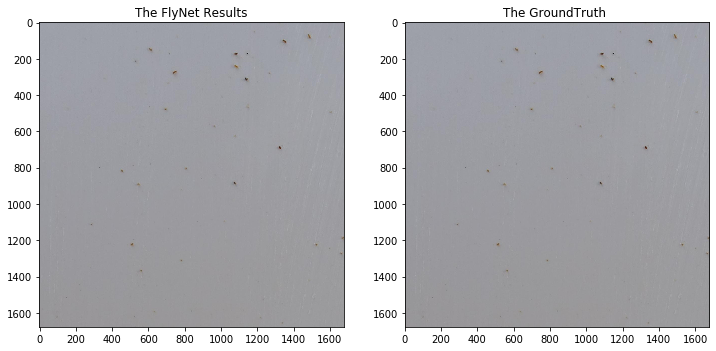

In [46]:
im_ind = 0
res = test(ic_test[im_ind], model_classification, model_yolo,0.9,0.1)
fig, ax = plt.subplots(1,2,figsize=(12,12))
for i in range(4):
    ax[0].imshow(ic_test[im_ind])
    ax[0].set_title("The FlyNet Results")
    ax[1].imshow(ic_test[im_ind])
    ax[1].set_title("The GroundTruth ")
    anno = res
    for num in anno:
        rect = patches.Rectangle((num[0], num[1]), num[2], num[3],
                    linewidth=1,edgecolor='r',facecolor='none')
        ax[0].add_patch(rect)
    anno = annotations_xmls_test[im_ind]
    for num in anno:
        rect = patches.Rectangle((num['bbox'][0], num['bbox'][1]), num['bbox'][2], num['bbox'][3],
                    linewidth=1,edgecolor='r',facecolor='none')
        ax[1].add_patch(rect)

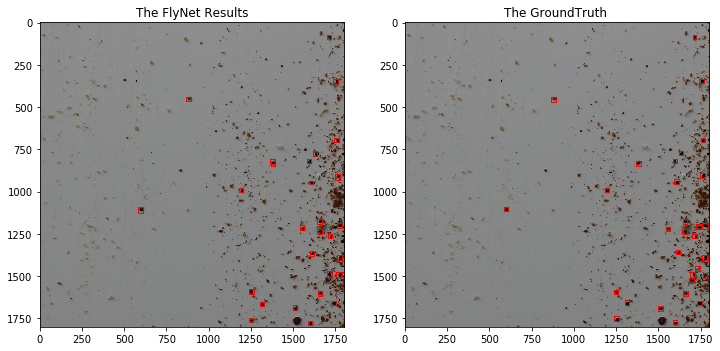

In [45]:
im_ind = 11
res = test(ic_test[im_ind], model_classification, model_yolo,0.9,0.1)
fig, ax = plt.subplots(1,2,figsize=(12,12))
for i in range(4):
    ax[0].imshow(ic_test[im_ind])
    ax[0].set_title("The FlyNet Results")
    ax[1].imshow(ic_test[im_ind])
    ax[1].set_title("The GroundTruth ")
    anno = res
    for num in anno:
        rect = patches.Rectangle((num[0], num[1]), num[2], num[3],
                    linewidth=1,edgecolor='r',facecolor='none')
        ax[0].add_patch(rect)
    anno = annotations_xmls_test[im_ind]
    for num in anno:
        rect = patches.Rectangle((num['bbox'][0], num['bbox'][1]), num['bbox'][2], num['bbox'][3],
                    linewidth=1,edgecolor='r',facecolor='none')
        ax[1].add_patch(rect)

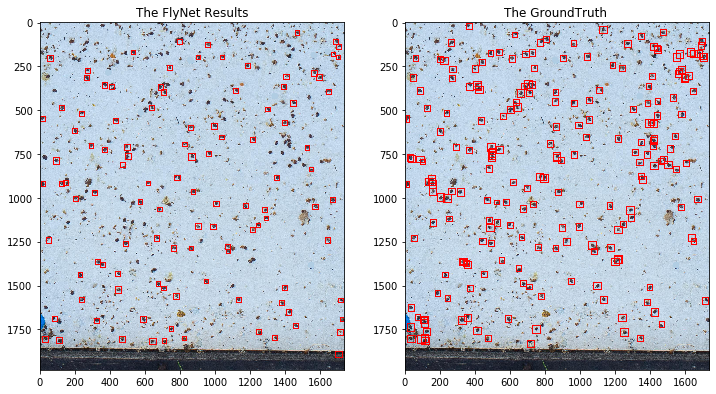

In [56]:
im_ind = 22
res = test(ic_test[im_ind], model_classification, model_yolo,0.9,0.1)
fig, ax = plt.subplots(1,2,figsize=(12,12))
for i in range(4):
    ax[0].imshow(ic_test[im_ind])
    ax[0].set_title("The FlyNet Results")
    ax[1].imshow(ic_test[im_ind])
    ax[1].set_title("The GroundTruth ")
    anno = res
    for num in anno:
        rect = patches.Rectangle((num[0], num[1]), num[2], num[3],
                    linewidth=1,edgecolor='r',facecolor='none')
        ax[0].add_patch(rect)
    anno = annotations_xmls_test[im_ind]
    for num in anno:
        rect = patches.Rectangle((num['bbox'][0], num['bbox'][1]), num['bbox'][2], num['bbox'][3],
                    linewidth=1,edgecolor='r',facecolor='none')
        ax[1].add_patch(rect)

## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

In [23]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

# We submit our challenges using Name: LookingForFly 